<a href="https://colab.research.google.com/github/Ibrah-N/Deep-Learning-Projects-Computer-Vision/blob/main/dl_16_transformer_encoder_from_scratch_and_hagging_transformer_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs & Imports

In [ ]:
!pip install -q kaggle

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf

## Data Loading & Preprocessing

In [ ]:
# setup the api

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# dowload dataset

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 96% 297M/309M [00:02<00:00, 147MB/s]
100% 309M/309M [00:02<00:00, 119MB/s]


In [ ]:
# copy dataset to mydrive

!cp human-emotions-datasethes.zip gdrive/MyDrive/

cp: cannot stat 'human-emotions-datasethes.zip': No such file or directory


In [ ]:
# Extract Downloaded Dataset
# !unzip -q human-emotions-datasethes.zip -d dataset/


# Extract Saved dataset
!unzip -q gdrive/MyDrive/human-emotions-datasethes.zip -d dataset/

In [ ]:
# Configurations

TRAIN_DIR = '/content/dataset/Emotions Dataset/Emotions Dataset/train/'
VAL_DIR = '/content/dataset/Emotions Dataset/Emotions Dataset/test/'


CONFIG = {
    'IM_SIZE' : 256,
    'BATCH_SIZE' : 32,
    'N_CLASSES': 3,
    'LABELS' : ['angry', 'happy', 'sad'],
    'EPOCHS' : 6,
    'SEED' : 42,
    'FILTER_SIZE': 16,
    'POOL_SIZE': 2,
    'PATCH_SIZE' : 16,
    'KERNEL_SIZE': 3,
    'DROPOUT_RATE': 0.0,
    'LEARNING_RATE': 0.0001,
    'DENSE_1': 32,
    'DENSE_2': 16,
    }


In [ ]:
# create tensorflow dataset

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIG['LABELS'],
    batch_size=None,
    image_size=(CONFIG['IM_SIZE'], CONFIG['IM_SIZE']),
    seed=CONFIG['SEED'],
)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIG['LABELS'],
    batch_size=None,
    image_size=(CONFIG['IM_SIZE'], CONFIG['IM_SIZE']),
    seed=CONFIG['SEED'],
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [ ]:
# rescalling data

def resize_rescale(image, label):
    image  = tf.image.resize(image, (CONFIG['IM_SIZE'], CONFIG['IM_SIZE']))
    image = tf.cast(image/255. , tf.float32)
    return image, label

In [ ]:
# train dataset prefetch

train_dataset = (
    train_dataset
    # .map(resize_rescale)
    .shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(CONFIG['BATCH_SIZE'])
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# validation dataset prefetch
validation_dataset = (
    validation_dataset
    # .map(resize_rescale)
    .shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(CONFIG['BATCH_SIZE'])
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
print(train_dataset.element_spec)
print(validation_dataset.element_spec)


(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))


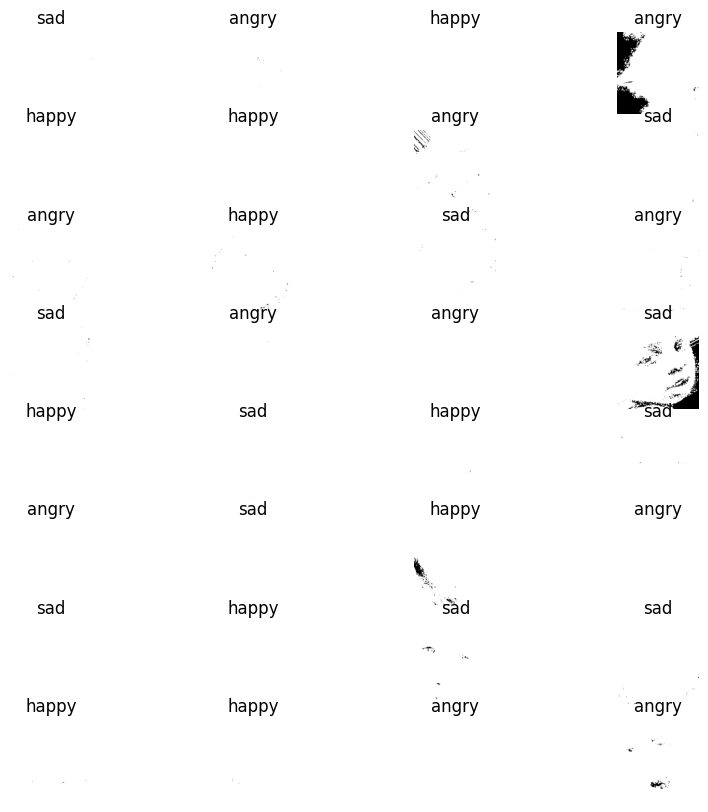

In [ ]:

# visulize batch data

def visulaize_batch(dataset, rows, cols):
  """
    dataset : batch dataset shape (batch, im_size, im_size, 3)
    rows : number of rows(int)
    cols : number of cols(int)
  """

  row = 0
  col = 0
  _, axs = plt.subplots(rows, cols, figsize=(10, 10))

  for x, y in train_dataset.take(1):
    for img, lbl in zip(x, y):
      if row == rows and col < cols:
        col += 1
        row = 0
      axs[row, col].imshow(img)
      axs[row, col].set_title(CONFIG['LABELS'][np.argmax(lbl)])
      axs[row, col].axis('off')
      row += 1


visulaize_batch(train_dataset.take(1), 8, 4)

## Transformer From Scritch

In [ ]:
# Extract the image

batch_img = train_dataset.take(1)
img_array = next(iter(batch_img))[0][0]

In [ ]:
patch_size = 16

patches = tf.image.extract_patches(
    images=tf.expand_dims(img_array, axis=0),
    sizes=[1, patch_size, patch_size, 1],
    strides=[1, patch_size, patch_size, 1],
    rates=[1, 1, 1, 1],
    padding='VALID',
)
patches.shape

TensorShape([1, 16, 16, 768])

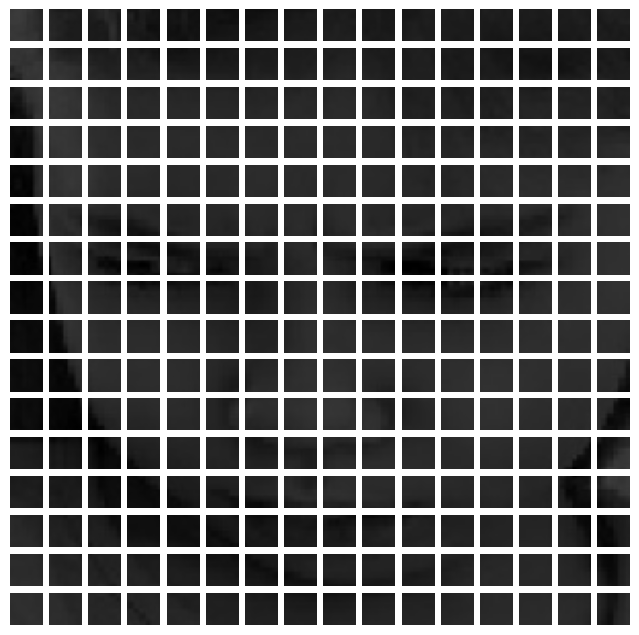

In [ ]:
plt.figure(figsize=(8, 8))
k = 0

for i in range(patch_size):
  for j in range(patch_size):
    plt.subplot(patch_size, patch_size, k+1)
    img = tf.reshape(patches[0, i , j , : ], (patch_size, patch_size, 3))
    plt.imshow(img)
    plt.axis('off')
    k += 1


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(Encoder, self).__init__(name='Encoder')
    self.n_patches = N_PATCHES
    self.hidden_size = HIDDEN_SIZE

    self.linear_projection = tf.keras.layers.Dense(units=HIDDEN_SIZE)
    self.position_embeding = tf.keras.layers.Embedding(input_dim=self.n_patches, output_dim=HIDDEN_SIZE)

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIG['PATCH_SIZE'], CONFIG['PATCH_SIZE'], 1],
        strides=[1, CONFIG['PATCH_SIZE'], CONFIG['PATCH_SIZE'], 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    print(patches.shape)

    patch = tf.shape(patches)[0]
    patches = tf.reshape(patches, (patch, 256, patches.shape[-1]))
    embeding_input = tf.range(start=0, limit=self.n_patches, delta=1)
    encoder = self.linear_projection(patches) + self.position_embeding(embeding_input)

    return encoder

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, N_HEAD, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name='TransformerEncoder')

    self.norm_1 = tf.keras.layers.LayerNormalization()
    self.norm_2 = tf.keras.layers.LayerNormalization()

    self.dropout = tf.keras.layers.Dropout(rate=0.1)
    self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=N_HEAD, key_dim=HIDDEN_SIZE)

    self.dense_1 = tf.keras.layers.Dense(HIDDEN_SIZE, tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(HIDDEN_SIZE, tf.nn.gelu)


  def call(self, input):

    # first layer
    x_1 = self.norm_1(input)
    x_1 = self.multi_head_attention(x_1, x_1)
    x_1 = tf.keras.layers.Add()([x_1, input])

    # second layer
    x_2 = self.norm_2(x_1)
    x_2 = self.dense_1(x_2)
    # x_2 = self.dropout(x_2)
    x_2 = self.dense_2(x_2)
    output = tf.keras.layers.Add()([x_2, x_1])

    return output

In [ ]:
class ViT(tf.keras.models.Model):
  def __init__(self, N_CLASSES, N_HEAD, N_LAYER, N_PATCHES, HIDDEN_SIZE, N_DENSE_UNIT):
    super(ViT, self).__init__(name='ViT')

    self.n_head = N_HEAD
    self.n_classes = N_CLASSES
    self.n_layer = N_LAYER
    self.n_patches = N_PATCHES
    self.hidden_size = HIDDEN_SIZE
    self.n_dense_unit = N_DENSE_UNIT


    self.patch_encoder = Encoder(self.n_patches, self.hidden_size)
    self.transformer_encoder = [TransformerEncoder(self.n_head, self.hidden_size) for _ in range(self.n_layer)]

    self.dense_1 = tf.keras.layers.Dense(self.n_dense_unit, tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(self.n_dense_unit, tf.nn.gelu)
    self.dense_3 = tf.keras.layers.Dense(self.n_classes, activation='softmax')


  def call(self, x, training=True):
    x = self.patch_encoder(x)

    for i in range(self.n_layer):
      x = self.transformer_encoder[i](x)

    x = tf.keras.layers.Flatten()(x)

    x = self.dense_1(x)
    x = self.dense_2(x)
    x = self.dense_3(x)

    return x

In [ ]:
ViT_model = ViT(N_CLASSES=3, N_HEAD=4, N_LAYER=2, N_PATCHES=256, HIDDEN_SIZE=768, N_DENSE_UNIT=512)
ViT_model(tf.zeros([32, 256, 256, 3]))
ViT_model.summary()

(32, 16, 16, 768)
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           multiple                  787200    
                                                                 
 TransformerEncoder (Transf  multiple                  10631424  
 ormerEncoder)                                                   
                                                                 
 TransformerEncoder (Transf  multiple                  10631424  
 ormerEncoder)                                                   
                                                                 
 dense_5 (Dense)             multiple                  100663808 
                                                                 
 dense_6 (Dense)             multiple                  262656    
                                                                 
 dense_7 (Dense)             multiple        

In [ ]:
ViT_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=tf.keras.losses.CategoricalCrossentropy()
)

In [ ]:
ViT_model.fit(train_dataset, epochs=CONFIG['EPOCHS'], validation_data=validation_dataset)

## Wandb

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
from wandb.keras import WandbCallback

In [ ]:
wandb.login(key="791da7778092369c33534951b74dedb4e5749326")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project = "ViT-Human-Emotion-Detection-SubClass", config=CONFIG)
CONFIG = wandb.config

wandb: Currently logged in as: ibrahnengineer. Use `wandb login --relogin` to force relogin


In [ ]:
def lr_scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * 0.1

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)


In [ ]:
# Log Confusion Metrix
class LogConfMetrixWandb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    log_data = validation_dataset.take(1)


    val_labels = []
    val_preds = []
    ### Extract Labels
    for data in log_data:
      for i in range(len(data[0])):
        # print("x", data[0][i].shape)
        val_labels.append(tf.argmax(data[1][i]).numpy())
        val_preds.append(tf.argmax(custom_vit(tf.expand_dims(data[0][i], axis=0))[0]).numpy())


    ### Log Confusion Metrix
    cm = wandb.plot.confusion_matrix(
        y_true=val_labels,
        preds=val_preds,
        class_names=CONFIG['LABELS']
    )
    wandb.log({'Confusion Metrix': cm})

In [ ]:
# Log Table
class LogTablesWandb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    log_data = validation_dataset.take(1)


    val_labels = []
    val_preds = []
    img_list = []
    ### Extract Labels
    for data in log_data:
      for i in range(len(data[0])):
        img_list.append(data[0][i])
        val_labels.append(tf.argmax(data[1][i]).numpy())
        val_preds.append(tf.argmax(custom_vit(tf.expand_dims(data[0][i], axis=0))[0]).numpy())


    ### Log Tables
    columns = ["Image", "Predicted", "Label"]
    table = wandb.Table(columns=columns)
    for i in range(len(val_labels)):
      table.add_data(wandb.Image(img_list[i]),
                CONFIG['LABELS'][val_preds[i]],
                CONFIG['LABELS'][val_labels[i]])


    wandb.log({'Table': table})

## Fine tunning hagging face transformer

In [ ]:
!pip install -q transformers
from transformers import TFViTModel

In [ ]:
# resize resclae

resize_rescale_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Permute((3, 1, 2))
])

In [ ]:

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [ ]:


input = tf.keras.layers.Input(shape=(256, 256, 3))
x = resize_rescale_layer(input)
x = base_model.vit(x)[0][:, 0, :]
output = tf.keras.layers.Dense(CONFIG['N_CLASSES'], activation='softmax')(x)

model = tf.keras.Model(inputs = input, outputs = output)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalCrossentropy()
)

In [ ]:
model.fit(train_dataset,
          epochs=CONFIG['EPOCHS'],
          validation_data=validation_dataset,
          verbose=1,
          callbacks=[WandbCallback(save_model=False), LogConfMetrixWandb(), LogTablesWandb()])

### CustomVit SubClass Model

In [ ]:
# Custom Hugging Face sub class model

class CustomVit(tf.keras.Model):
  def __init__(self, n_classes, **kwargs):
    super(CustomVit, self).__init__(name="CustomVit-Model")


    self.resize_rescale_layer = tf.keras.Sequential([
        tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Permute((3, 1, 2))
    ])

    self.base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    self.classifier = tf.keras.layers.Dense(CONFIG['N_CLASSES'], activation='softmax')


  def call(self, input):

    x = self.resize_rescale_layer(input)
    x = self.base_model.vit(x)[0][:, 0, :]
    output = self.classifier(x)

    return output

In [ ]:
custom_vit = CustomVit(CONFIG['N_CLASSES'])
# custom_vit(tf.zeros([32, 256, 256, 3]))
# custom_vit.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
custom_vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [ ]:
custom_vit.fit(train_dataset,
          epochs=CONFIG['EPOCHS'],
          validation_data=validation_dataset,
          verbose=1,
          callbacks=[WandbCallback(save_model=False), LogConfMetrixWandb(), LogTablesWandb(), lr_callback])

Epoch 1/6


213/213 [==============================] - 388s 2s/step - loss: 0.4866 - categorical_accuracy: 0.7981 - val_loss: 0.3445 - val_categorical_accuracy: 0.8551 - lr: 1.0000e-04
Epoch 2/6
213/213 [==============================] - 309s 1s/step - loss: 0.2560 - categorical_accuracy: 0.9019 - val_loss: 0.2875 - val_categorical_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 3/6
213/213 [==============================] - 312s 1s/step - loss: 0.1750 - categorical_accuracy: 0.9328 - val_loss: 0.3385 - val_categorical_accuracy: 0.8828 - lr: 1.0000e-04
Epoch 4/6
213/213 [==============================] - 308s 1s/step - loss: 0.0840 - categorical_accuracy: 0.9666 - val_loss: 0.3130 - val_categorical_accuracy: 0.8938 - lr: 1.0000e-05
Epoch 5/6
213/213 [==============================] - 313s 1s/step - loss: 0.0622 - categorical_accuracy: 0.9766 - val_loss: 0.3189 - val_categorical_accuracy: 0.8933 - lr: 1.0000e-06
Epoch 6/6
213/213 [==============================] - 309s 1s/step - loss: 0.0599 - categorical_

In [ ]:
custom_vit.save("human-emotion-detection-vit-model", save_format = 'tf')

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 14.7 MB/s eta 0:00:00


In [ ]:
!python -m tf2onnx.convert --saved-model custom_vit --output human-emotion-detection-custom-vit.onnx

In [ ]:
!cp -r human-emotion-detection-vit-model gdrive/MyDrive/dl_models/

In [ ]:
!cp -r human-emotion-detection-tf-vit-model.onnx gdrive/MyDrive/dl_models/

In [ ]:
wandb.finish()